In [1]:
# import libraries
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from torchsummary import summary

In [2]:
import sys
sys.path.append("../")
sys.path.append("../../")

import os
import random
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from predict import predict, get_confidence_intervals
from open_data import open_data, create_global_batch,get_df_stats,apply_norm
from dataset import RadarDataset, RadarCollate
from simple_model import LSTM
from bayesian_lstm_model import BayesLSTM
from train import train
import constant

In [3]:
PATH_CSV= "/Users/clemencevast/Documents/Courses/MachineLearning/RadarTrafficData_files/Radar_Traffic_Counts.csv" #"/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv"
radar_name=' CAPITAL OF TEXAS HWY / LAKEWOOD DR'
DAYS_INPUT=7
WINDOW_LABEL=1
INPUT_SIZE=(DAYS_INPUT)*24*4 # 7*24*4 = 672
OUTPUT_SIZE=(WINDOW_LABEL)*24*4 # 7*24*4 = 672
TOTAL_DAYS=365

In [4]:
df1=open_data(PATH_CSV, direction="NB", radar=radar_name, year=2018)

In [5]:
batch_df=create_global_batch(df1, window_x_day=DAYS_INPUT, window_label_day=WINDOW_LABEL, gap_acquisition=1, tot_len_day=TOTAL_DAYS)

In [6]:
batch_df

,vol_data_x,vol_label_y
0,"[22.0, 13.0, 21.0, 21.0, 15.0, 11.0, 19.0, 5.0...","[66, 40, 40, 22, 28, 22, 13, 9, 10, 14, 17, 7,..."
1,"[33.0, 31.0, 20.0, 22.0, 13.0, 13.0, 13.0, 9.0...","[36, 32, 28, 26, 23, 20, 14, 21, 8, 9, 11, 9, ..."
2,"[32.0, 31.0, 25.0, 29.0, 29.0, 10.0, 21.0, 17....","[48, 32, 36, 28, 32, 23, 8, 22, 17, 7, 21, 15,..."
3,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38, 38, 26, 21, 26, 22, 18, 11, 2, 4, 8, 6, 1..."
4,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35, 35, 35, 23, 23, 14, 13, 13, 8, 6, 9, 9, 6..."
...,...,...
170,"[39, 31, 27, 14, 10, 9, 9, 16, 12, 9, 9, 4, 10...","[54, 31, 33, 34, 16, 15, 12, 15, 10, 13, 10, 3..."
171,"[44, 35, 31, 26, 12, 16, 26, 11, 14, 13, 6, 11...","[38, 35, 29, 18, 11, 20, 11, 14, 9, 13, 6, 7, ..."
172,"[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...","[41, 42, 32, 32, 20, 13, 22, 15, 10, 8, 5, 11,..."
173,"[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...","[63, 52, 39, 29, 25, 17, 19, 18, 10, 8, 6, 9, ..."


In [7]:
df_mean,df_std=get_df_stats(batch_df)
new_data=apply_norm(batch_df,df_mean,df_std)

In [8]:
get_df_stats(new_data,["vol_data_x_norm","vol_label_y_norm"])

(0.0, 1.0)

In [9]:
batch_df

,vol_data_x,vol_label_y,vol_data_x_min,vol_data_x_max,vol_label_y_min,vol_label_y_max,vol_data_x_norm,vol_label_y_norm,vol_data_x_norm_min,vol_data_x_norm_max,vol_label_y_norm_min,vol_label_y_norm_max
0,"[22.0, 13.0, 21.0, 21.0, 15.0, 11.0, 19.0, 5.0...","[66, 40, 40, 22, 28, 22, 13, 9, 10, 14, 17, 7,...",0.0,870.0,4.0,474.0,"[0.022610483042137718, 0.013360739979445015, 0...","[0.06783144912641316, 0.041109969167523124, 0....",0.000000,0.894142,0.004111,0.487153
1,"[33.0, 31.0, 20.0, 22.0, 13.0, 13.0, 13.0, 9.0...","[36, 32, 28, 26, 23, 20, 14, 21, 8, 9, 11, 9, ...",0.0,870.0,2.0,470.0,"[0.03391572456320658, 0.03186022610483042, 0.0...","[0.03699897225077081, 0.0328879753340185, 0.02...",0.000000,0.894142,0.002055,0.483042
2,"[32.0, 31.0, 25.0, 29.0, 29.0, 10.0, 21.0, 17....","[48, 32, 36, 28, 32, 23, 8, 22, 17, 7, 21, 15,...",0.0,870.0,5.0,477.0,"[0.0328879753340185, 0.03186022610483042, 0.02...","[0.04933196300102775, 0.0328879753340185, 0.03...",0.000000,0.894142,0.005139,0.490236
3,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[38, 38, 26, 21, 26, 22, 18, 11, 2, 4, 8, 6, 1...",0.0,789.0,2.0,481.0,"[0.013360739979445015, 0.0051387461459403904, ...","[0.03905447070914697, 0.03905447070914697, 0.0...",0.000000,0.810894,0.002055,0.494347
4,"[34.0, 29.0, 28.0, 26.0, 17.0, 14.0, 15.0, 5.0...","[35, 35, 35, 23, 23, 14, 13, 13, 8, 6, 9, 9, 6...",0.0,505.0,5.0,635.0,"[0.03494347379239465, 0.029804727646454265, 0....","[0.03597122302158273, 0.03597122302158273, 0.0...",0.000000,0.519013,0.005139,0.652621
...,...,...,...,...,...,...,...,...,...,...,...,...
170,"[39, 31, 27, 14, 10, 9, 9, 16, 12, 9, 9, 4, 10...","[54, 31, 33, 34, 16, 15, 12, 15, 10, 13, 10, 3...",4.0,487.0,3.0,488.0,"[0.040082219938335044, 0.03186022610483042, 0....","[0.05549845837615622, 0.03186022610483042, 0.0...",0.004111,0.500514,0.003083,0.501542
171,"[44, 35, 31, 26, 12, 16, 26, 11, 14, 13, 6, 11...","[38, 35, 29, 18, 11, 20, 11, 14, 9, 13, 6, 7, ...",3.0,488.0,4.0,484.0,"[0.045220966084275435, 0.03597122302158273, 0....","[0.03905447070914697, 0.03597122302158273, 0.0...",0.003083,0.501542,0.004111,0.497431
172,"[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...","[41, 42, 32, 32, 20, 13, 22, 15, 10, 8, 5, 11,...",3.0,488.0,5.0,501.0,"[0.05960945529290853, 0.02877697841726619, 0.0...","[0.0421377183967112, 0.04316546762589928, 0.03...",0.003083,0.501542,0.005139,0.514902
173,"[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...","[63, 52, 39, 29, 25, 17, 19, 18, 10, 8, 6, 9, ...",3.0,501.0,6.0,480.0,"[0.051387461459403906, 0.041109969167523124, 0...","[0.06474820143884892, 0.05344295991778006, 0.0...",0.003083,0.514902,0.006166,0.493320


In [10]:
batch_size = 1

In [11]:
fullset = RadarDataset(dataframe=batch_df,transform=None)
ptrain,pval,ptest=0.8,0.05,0.15
trainglobdataset, testdataset = train_test_split(fullset, test_size=ptest,shuffle=False)
traindataset, valdataset = train_test_split(trainglobdataset, test_size=pval/(1-ptest),shuffle=False)

(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,

In [12]:
collate_fn = RadarCollate()
trainloader = DataLoader(traindataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valloader = DataLoader(valdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
testloader = DataLoader(testdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [13]:
print(traindataset)

[(array([0.02261048, 0.01336074, 0.02158273, 0.02158273, 0.01541624,
       0.01130524, 0.01952724, 0.00513875, 0.01438849, 0.0061665 ,
       0.00513875, 0.00822199, 0.004111  , 0.00719424, 0.01130524,
       0.00924974, 0.00822199, 0.00822199, 0.01336074, 0.02261048,
       0.02980473, 0.03494347, 0.03905447, 0.05755396, 0.08119219,
       0.10174717, 0.12846865, 0.22610483, 0.21891059, 0.2672148 ,
       0.32271326, 0.40390545, 0.41315519, 0.35149024, 0.44604317,
       0.36176773, 0.45940391, 0.35662898, 0.34121274, 0.36690647,
       0.37410072, 0.35457348, 0.30832477, 0.327852  , 0.28365879,
       0.32887975, 0.38437821, 0.34635149, 0.41007194, 0.41315519,
       0.4049332 , 0.41932169, 0.39362795, 0.37204522, 0.37512847,
       0.40390545, 0.34737924, 0.37512847, 0.34532374, 0.44707091,
       0.336074  , 0.38540596, 0.44193217, 0.42651593, 0.43576567,
       0.23021583, 0.26618705, 0.48612539, 0.22096608, 0.46659815,
       0.46248715, 0.46248715, 0.45632066, 0.49023638, 0.353

In [14]:
c= 0
for x in trainloader:
    print("batch number {}".format(c))
    print(x[0].shape, x[1].shape, "\n")
    #print(x)
    c+=1

batch number 0
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 1
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 2
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 3
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 4
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 5
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 6
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 7
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 8
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 9
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 10
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 11
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 12
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 13
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 14
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 15
torch.Size([1, 672]) torch.Size([1, 96]) 

batch number 16
torch.Size([1, 672]) torch.Size([1, 96]) 

batch n

## Modèle Bayesian LSTM

In [17]:
input_dim = INPUT_SIZE   
hidden_dim = 70
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1

lr2 = 0.001
n_epochs = 100
iterations_per_epoch = len(trainloader)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BayesLSTM(input_size=input_dim, hidden_size=hidden_dim, output_size=output_dim)
name_model="bayesian_model_smalldataset_lre-4"

In [203]:
iteration2,loss_train_list2,loss_val_list2=train(model, trainloader, valloader, lr=lr2, n_epochs=n_epochs, name_model=name_model, device=device,ite_print=2,save=True, is_bayes=True, sample_nbr=3)

/Users/clemencevast/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 96])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 loss train 644502.1875 loss val 0.01152267400175333
epoch 3 loss train 621361.8125 loss val 0.006669890601187944
epoch 5 loss train 599300.1875 loss val 0.0053890664130449295
epoch 7 loss train 577502.0 loss val 0.0051980759017169476
epoch 9 loss train 555550.3125 loss val 0.005025178659707308
epoch 11 loss train 533707.8125 loss val 0.005327350925654173
epoch 13 loss train 512177.75 loss val 0.005247935652732849
epoch 15 loss train 490153.5 loss val 0.005190317053347826
epoch 17 loss train 468398.34375 loss val 0.005059165880084038
epoch 19 loss train 446784.15625 loss val 0.0055040111765265465
epoch 21 loss train 425170.09375 loss val 0.005023675039410591
epoch 23 loss train 403786.25 loss val 0.005253581330180168
epoch 25 loss train 382361.65625 loss val 0.004899481777101755
epoch 27 loss train 361024.25 loss val 0.005154864862561226
epoch 29 loss train 339440.28125 loss val 0.005187900736927986
epoch 31 loss train 318593.0 loss val 0.005165548995137215
epoch 33 loss train 2

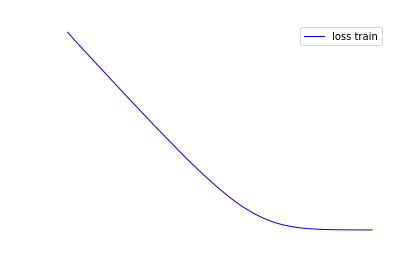

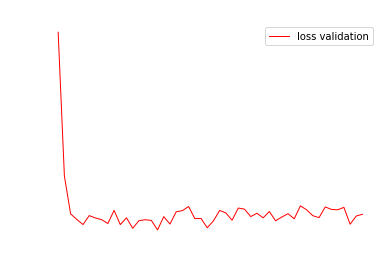

In [204]:
fig,ax=plt.subplots()
ax.set_title("Bayesian LSTM train loss", color="white")
ax.plot(iteration2,loss_train_list2,"b",label="loss train")
ax.legend()

fig,ax=plt.subplots()
ax.set_title("Bayesian LSTM validation loss", color="white")
ax.plot(iteration2,loss_val_list2,"r",label="loss validation")
ax.legend()

In [18]:
PATH_MODEL= constant.MODEL_DIR + name_model +".pt"
prediction, gt, mse_list=predict(PATH_MODEL,testloader, is_interval=True, sample_nbr=3)

/Users/clemencevast/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 96])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [19]:
ci_multiplier=10

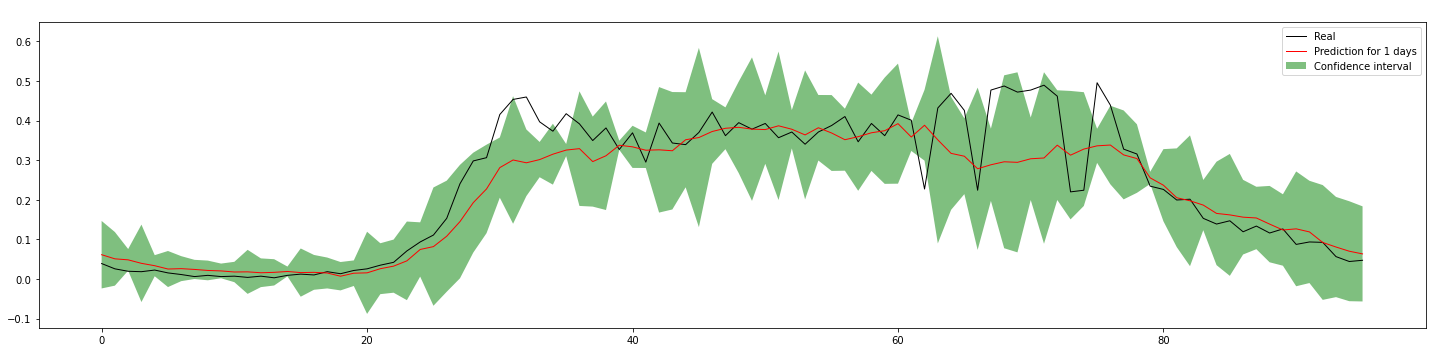

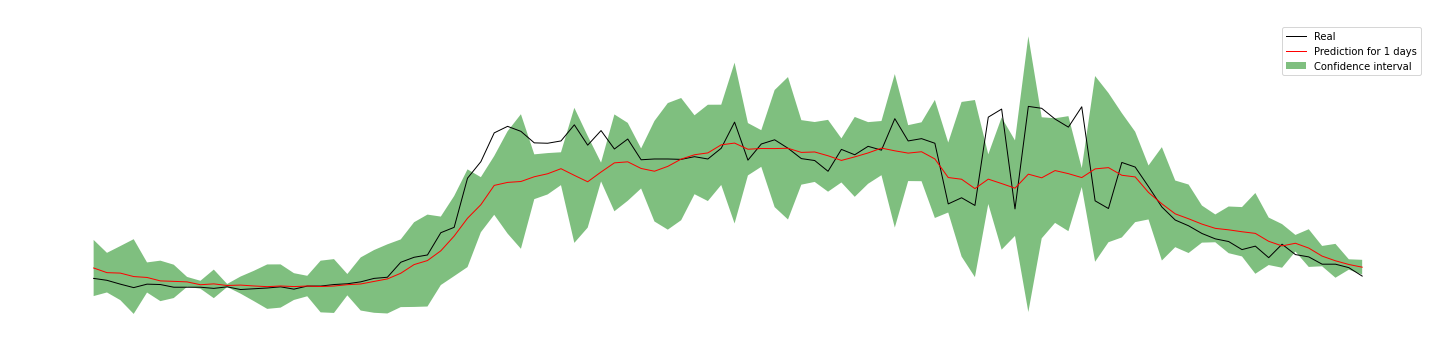

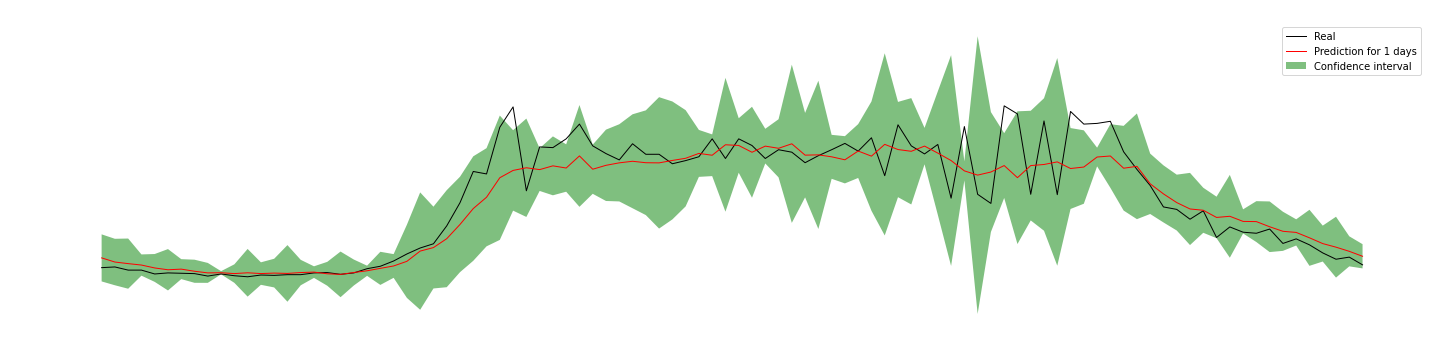

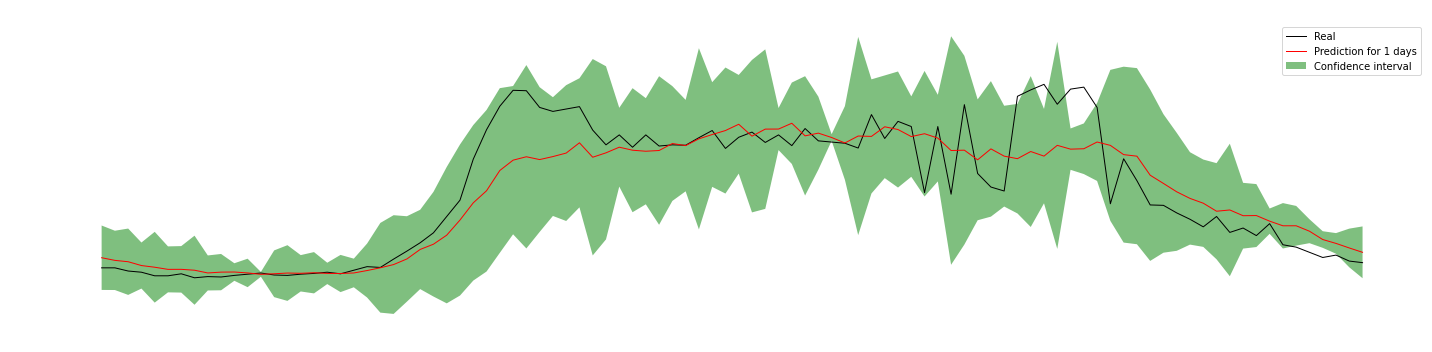

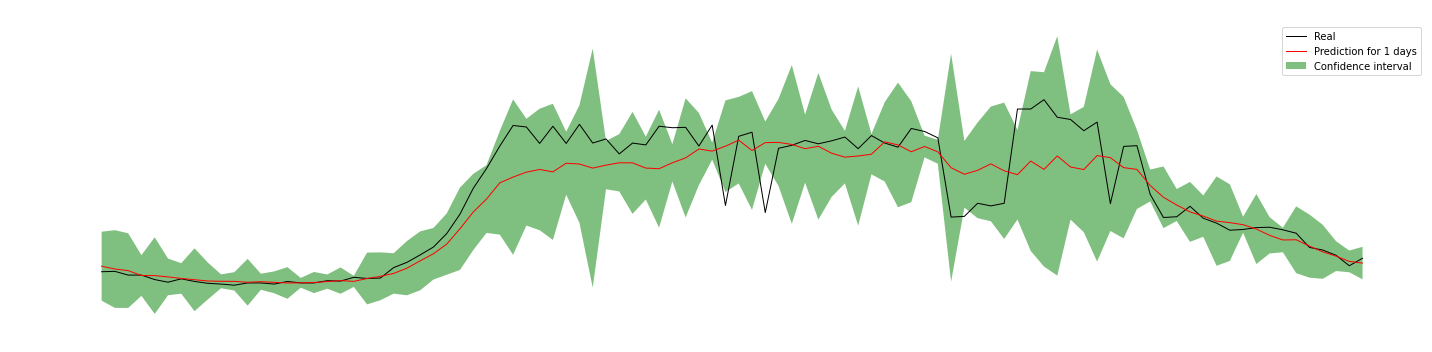

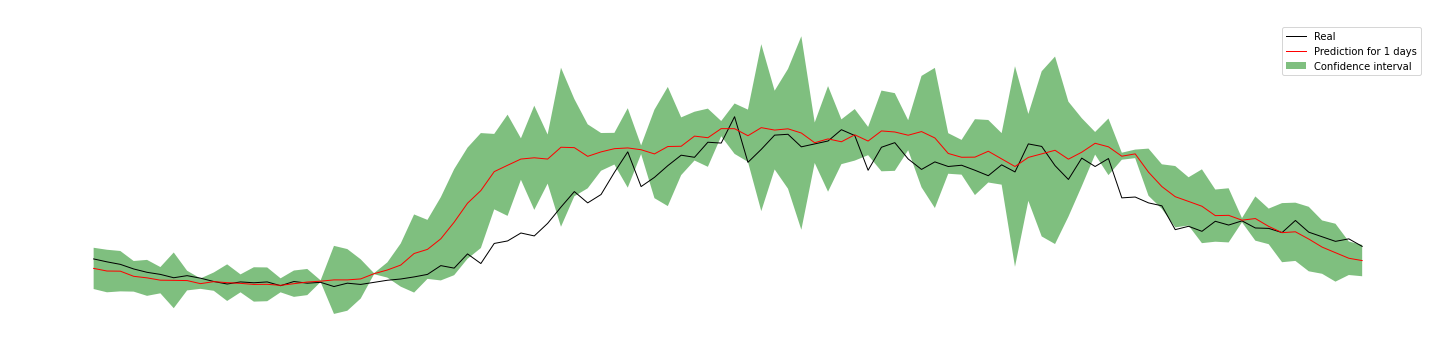

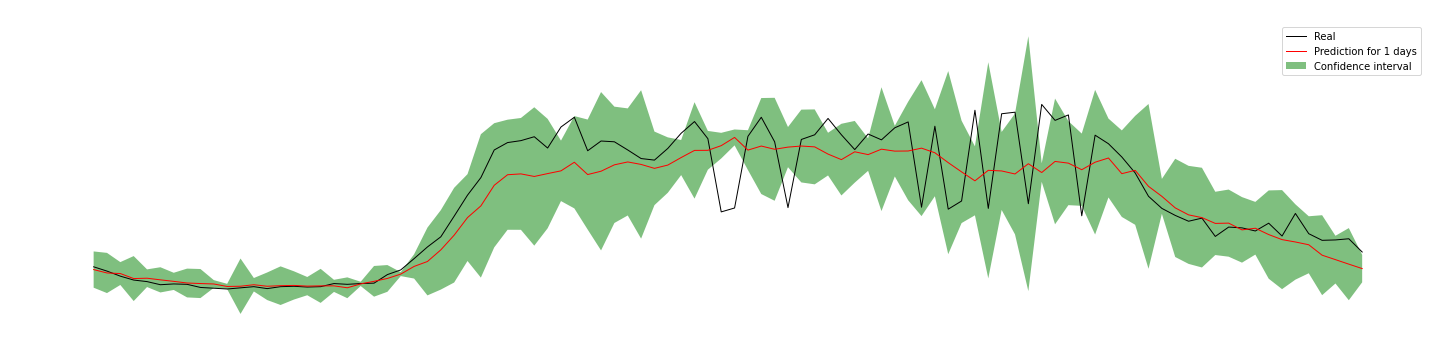

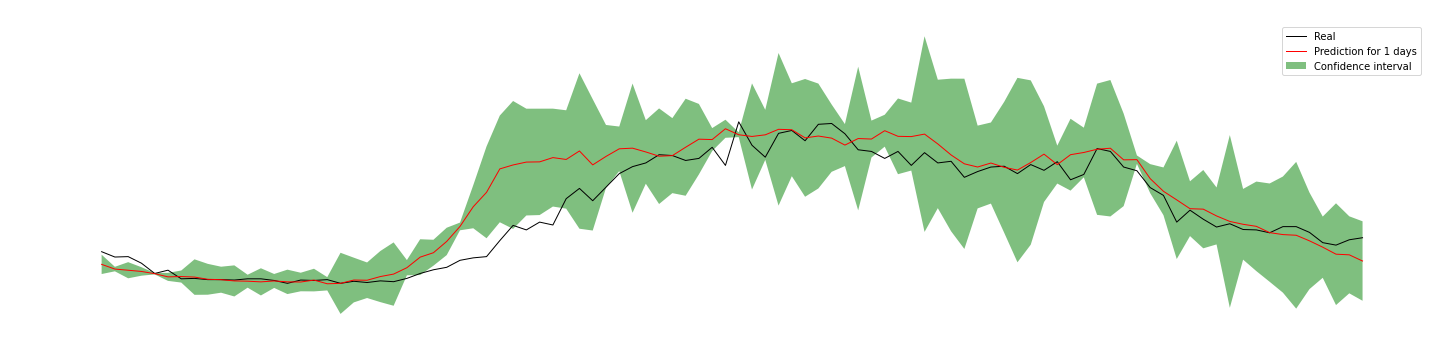

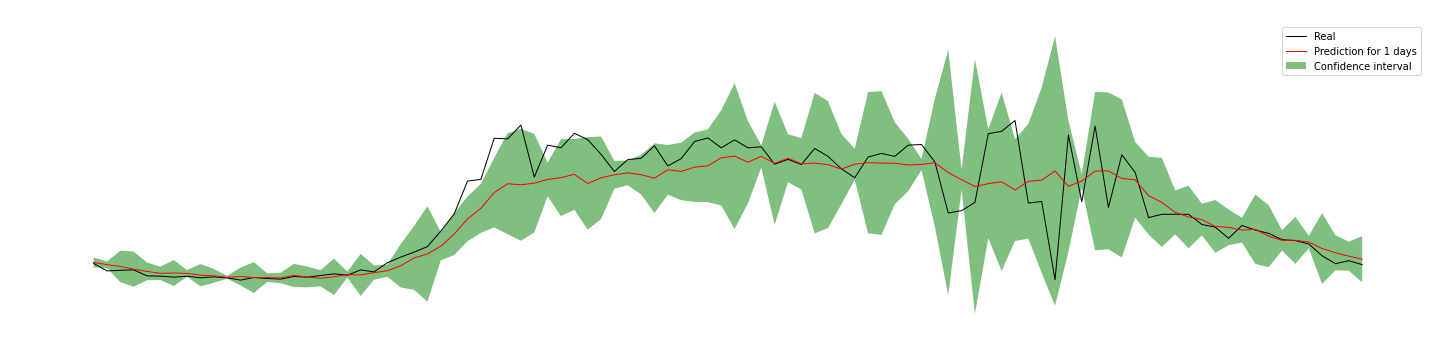

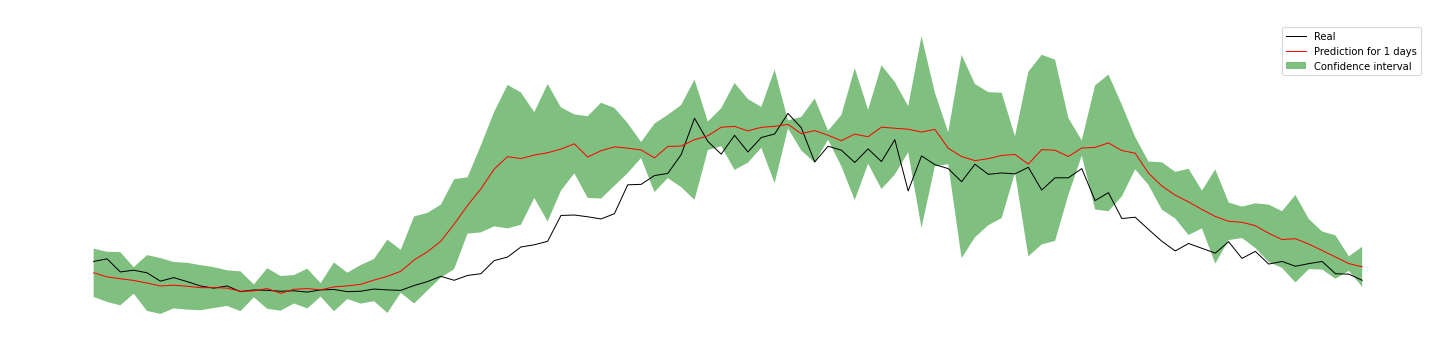

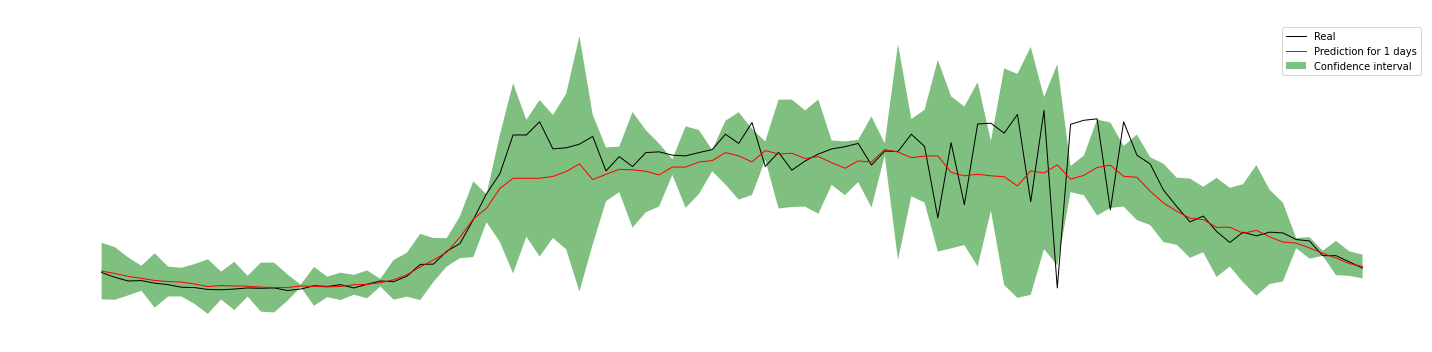

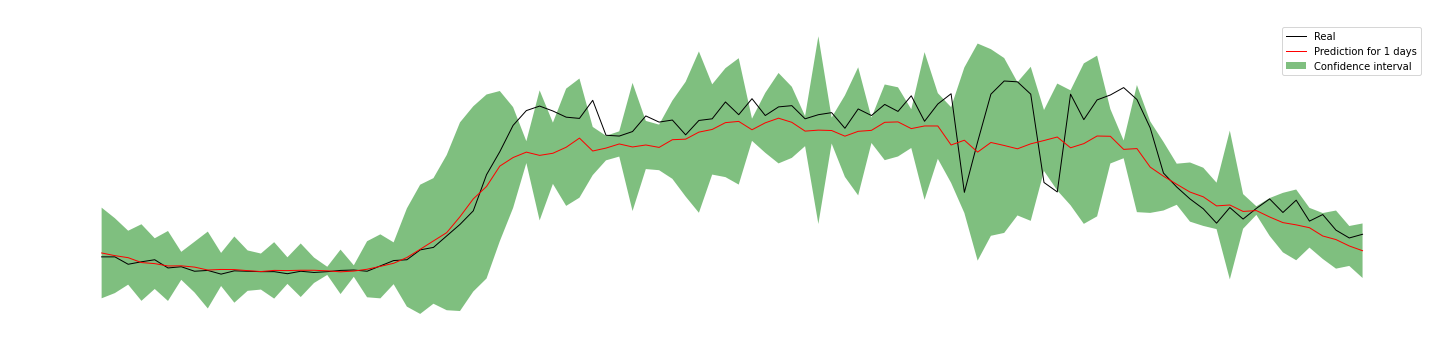

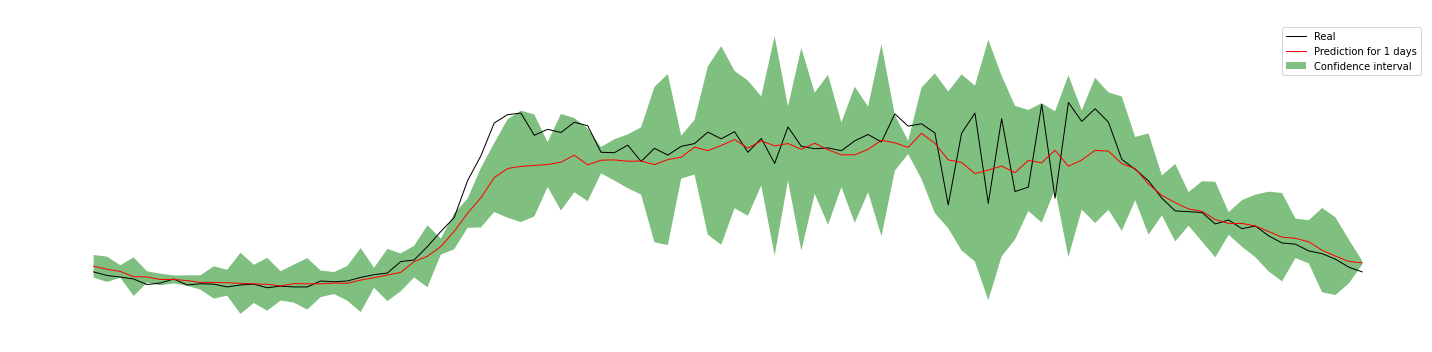

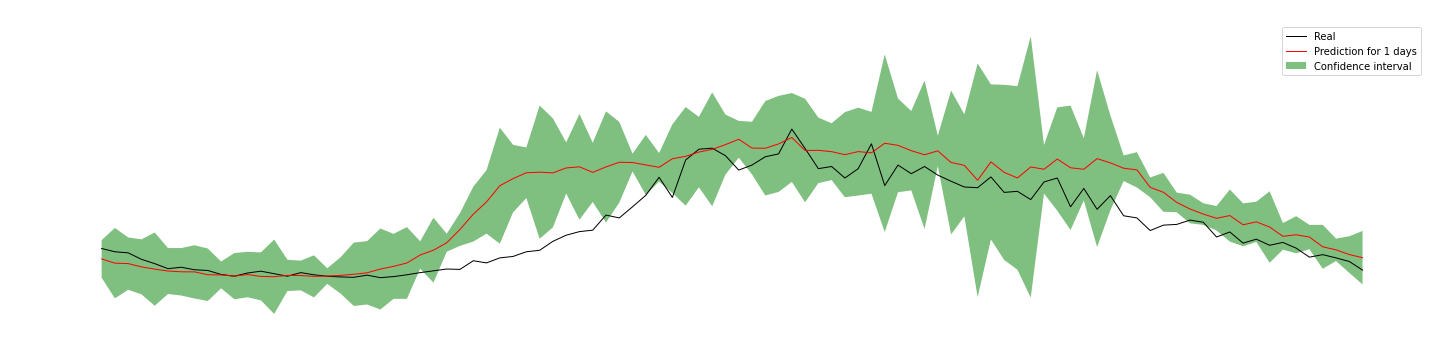

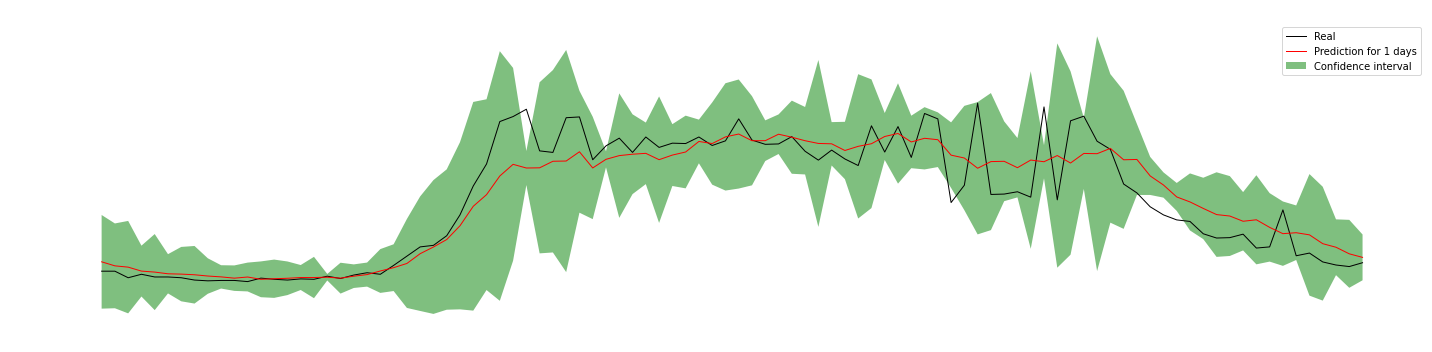

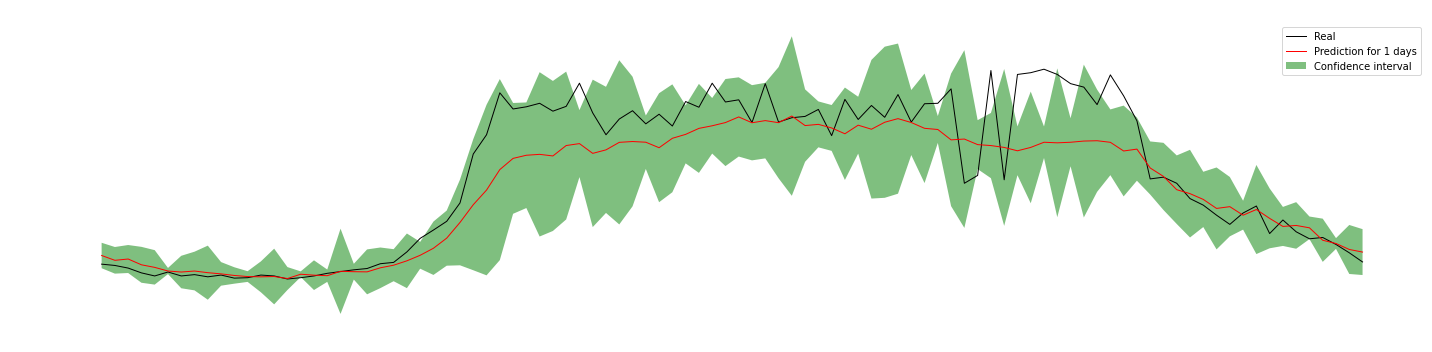

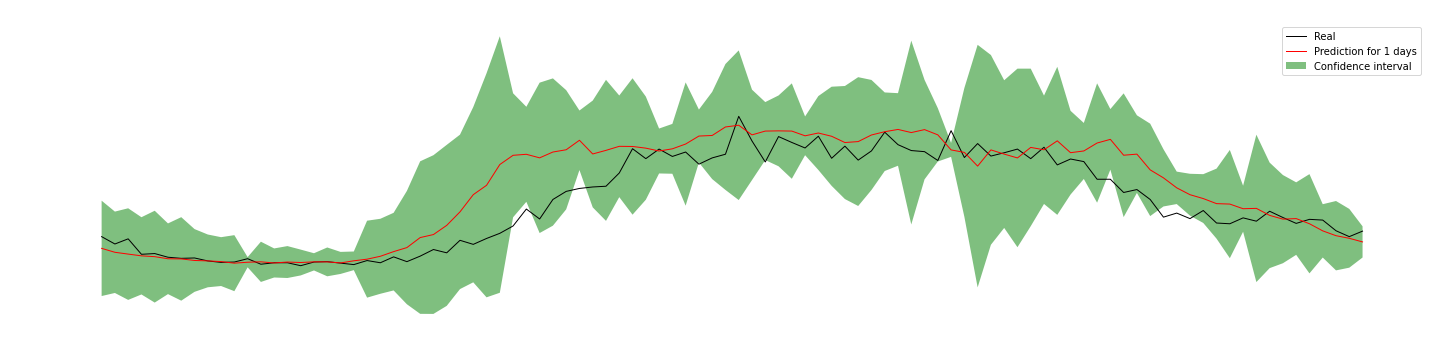

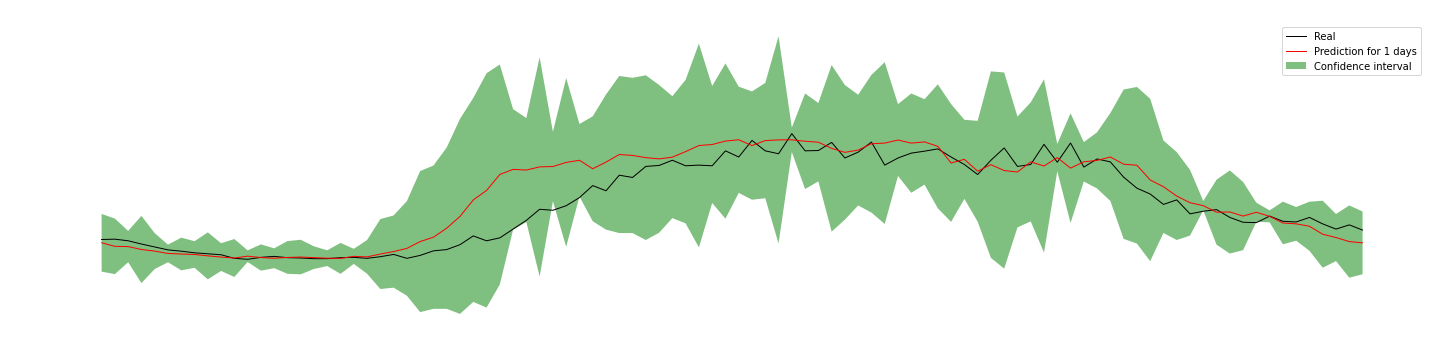

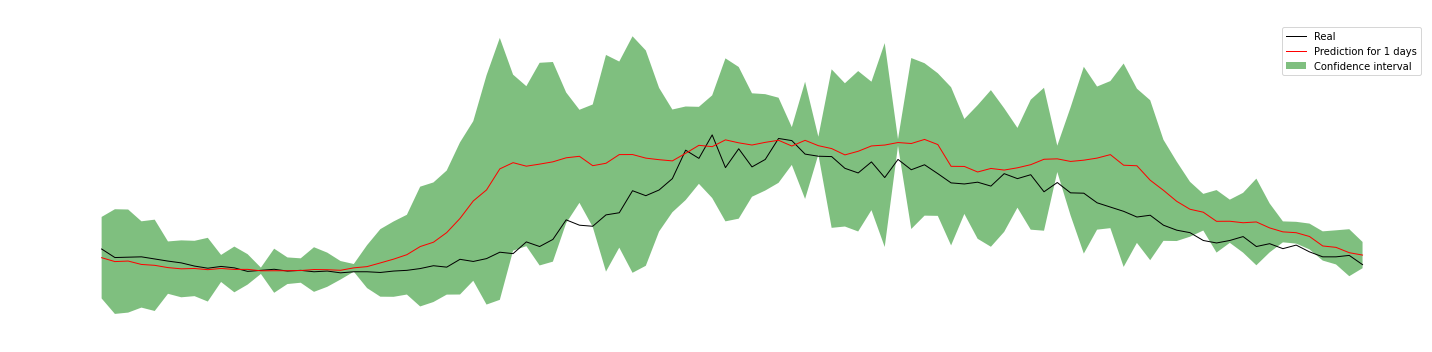

In [20]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          'lines.linewidth': 1}

for i in range(19):
    fig,ax=plt.subplots(figsize=(20, 5))
    plt.rcParams.update(params)

    plt.title("Predictions for set {}".format(i), color="white")
    
    pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(prediction[i], ci_multiplier)
    index_pred = [i for i in range(len(pred_mean_unscaled))]
    arr_gt=gt[i].detach().numpy()
    ax.plot(index_pred,
             arr_gt.ravel(),
             color='black',
             label="Real")
    
    ax.plot(index_pred,
             pred_mean_unscaled,
             label="Prediction for {} days".format(WINDOW_LABEL),
             color="red")

    ax.fill_between(x=index_pred,
                     y1=upper_bound_unscaled[:,0],
                     y2=lower_bound_unscaled[:,0],
                     facecolor='green',
                     label="Confidence interval",
                     alpha=0.5)

    plt.legend()
    plt.tight_layout()